# Naivní Bayesův klasifikátor

V tomto notebooku se budeme zabývat řešením problému klasifikace pomocí metody nazývané Naivní Bayes (Naive Bayes).

Dokumentace a příklady scikit-learn jsou dostupné [zde](https://scikit-learn.org/stable/modules/naive_bayes.html).

Pro data s diskrétními hodnotami příznaků je MAP odhad predikované proměnné $Y$ naivního Bayesova klasifikátoru roven
$$
\hat Y = \arg \max_{y \in \mathcal Y} \Pi_{i = 1}^{p} \, P(X_i = x_i | Y = y) P(Y = y).
$$

## Bernoulli Naive Bayes

Uvažujme jako na přednášce data obsahující tři binární příznaky $X_1, X_2, X_3$ a binární vysvětlovanou proměnnou $Y$

$$
\begin{array}{c|ccc}
          Y & X_1 & X_2 & X_3 \\
          \hline
          1 & 1 & 1 & 0 \\
          1 & 0 & 1 & 1 \\
          1 & 1 & 1 & 1 \\
          0 & 0 & 0 & 1 \\
          0 & 0 & 1 & 0 \\
          0 & 1 & 0 & 0 \\
        \end{array}
$$

Data byla generována tak, že ve skutečnosti jsou $X_1, X_2, X_3$ nezávislé veličiny se stejným rovnoměrným rozdělením,
$X_i \sim Be(1/2)$, a $Y = 1$ právě, když jsou alespoň dvě hodnoty příznaků rovny $1$.

In [1]:
import numpy as np

X = np.array([
    [1,1,0],
    [0,1,1],
    [1,1,1],
    [0,0,1],
    [0,1,0],
    [1,0,0],
])
Y = np.array([1,1,1,0,0,0])

Implementace `BernoulliNB(*, alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)` v knihovně scikit-learn nám umožní model rovnou natrénovat jelikož příznaky jsou již binární. Pokud tomu tak není, lze zadat parametr `binarize` určující hranici pro reprezentaci dat pomocí $0$ a $1$. 

Při výchozi volbě parametru `alpha = 1.0` se aposteriorní rozdělení počítají jako
$$
\hat p_y = \frac{N_{1,y} + 1}{N_{1,y} + N_{0,y} + 2}.
$$

In [2]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(alpha=1.0);
clf.fit(X, Y);

In [3]:
print('třídy y:', clf.classes_)
print('počet vzorků pro každou třídu:',clf.class_count_)
print('počty vzorků pro každou třídu a příznak:\n', clf.feature_count_)

třídy y: [0 1]
počet vzorků pro každou třídu: [3. 3.]
počty vzorků pro každou třídu a příznak:
 [[1. 1. 1.]
 [2. 3. 2.]]


Odhady pravděpodobností $\Pi_{i = 1}^p \, P(X_i = x_i | Y = y) P(Y = y)$ a výsledná predikce na trénovací množině.

In [4]:
print('odhad pravděpodobnosti pro vektory X:\n',clf.predict_proba(X))

print('predikce pro vektory X:\n',clf.predict(X))

odhad pravděpodobnosti pro vektory X:
 [[0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.18181818 0.81818182]
 [0.75       0.25      ]
 [0.52941176 0.47058824]
 [0.75       0.25      ]]
predikce pro vektory X:
 [1 1 1 0 0 0]


Nyní přistupme k predikci pro vektory $\{(1,0,1),(0,0,0)\}$.

In [5]:
to_predict = np.array([[1,0,1],[0,0,0]])
print('odhady pravděpodobností jsou:\n',clf.predict_proba(to_predict))
print('tedy vektory klasifikujeme jako:\n',clf.predict(to_predict))

odhady pravděpodobností jsou:
 [[0.57142857 0.42857143]
 [0.87096774 0.12903226]]
tedy vektory klasifikujeme jako:
 [0 0]


Úkol: vyzkoušejte použití `BernoulliNB()` pro různé hodnoty parametru `alpha` a zkoumejte vliv na odhad pravděpodobností.

## Gaussian Naive Bayes

Uvažujme nyní dataset Iris známý z dřívějška. Proměnná $X$ obsahuje příznaky, proměnná $y$ predikovanou třídu. Tentokrát jsou ale $X$ spojité.

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print('Shape X_train:', X_train.shape)

Shape X_train: (100, 4)


Vykreslíme si histogramy hodnot jednotlivých příznaků $X_{train}$ v trénovací množině.

In [7]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

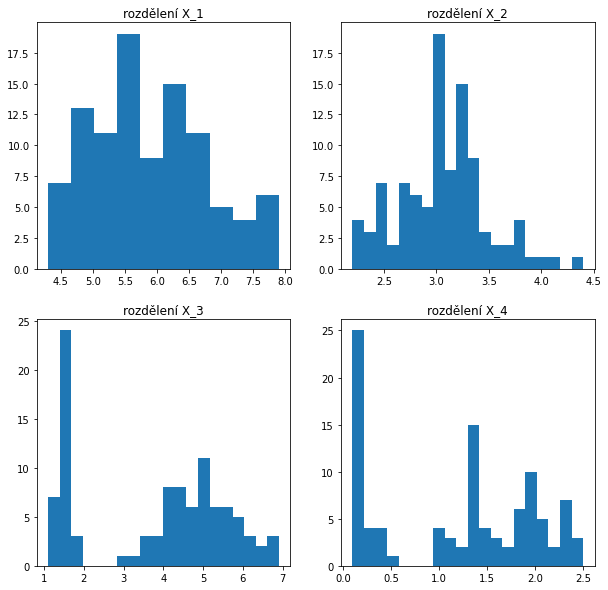

In [8]:
plt.figure(figsize=(10,10));
plt.subplot(221); plt.title('rozdělení X_1'); plt.hist(X_train[:,0],bins=10);
plt.subplot(222); plt.title('rozdělení X_2'); plt.hist(X_train[:,1],bins=20);
plt.subplot(223); plt.title('rozdělení X_3'); plt.hist(X_train[:,2],bins=20);
plt.subplot(224); plt.title('rozdělení X_4'); plt.hist(X_train[:,3],bins=20);

Z histogramů není jasné jaké rozdělení by příznaky $X_i$ mohly mít, tedy jaká by měla být hustota pravděpodobnosti $f_{X_i}(x_i)$. Částečně za to může i fakt se kterým jsme se setkali dříve, totiž že v datasetu se jedna třída od ostatních viditelně liší (v histogramu bude více vrcholů).

Nás ale zajímá podmíněná hustota pravděpodobnosti $f_{X_i|y}(x_i)$, protože Gaussovský naivní Bayes provádí MAP odhad pomocí
$$
\hat Y = \arg \max_{y \in \mathcal Y} \prod_{i = 1}^p f_{X_i | y}(x_i) P(Y = y).
$$
Příslušné histogramy pro jednotlivé třídy získáme tak, že v předchozím nahradíme `X_train` pomocí `X_train[y_train == i]`. Situace se přesto příliš nezlepší, protože dat potom není mnoho.

Přijmeme teď předpoklad, že podmíněná rozdělení $X_i | Y = y$ jsou normální rozdělení       $N(\mu_y,\sigma^2_y)$ se střední hodnotou určenou parametrem $\mu_y$ a rozptylem určeným parametrem $\sigma^2_y$ a podmíněná hustota je tedy pro každé $x \in \mathbb R$ určena vztahem
$$
f_{X | y}(x) = \frac{1}{\sqrt{2\pi \sigma_y^2}} \exp\left(-\frac{1}{2\sigma^2_y}(x - \mu_y)^2\right).
$$
Použijeme navíc odhady
$$
\hat \mu_y = \frac{1}{N_y}\sum_{i}^{N_y} x_i, \quad \hat \sigma^2_y = \frac{1}{N_y}\sum_{i}^{N_y} (x_i - \hat \mu_y)^2,
$$
kde $x_1,\dotsc,x_{N_y}$ jsou hodnoty příznaku $X$, pro které $Y = y$.

Vše potřebné je ve scikit-learn již implementováno.

In [9]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB();
clf.fit(X_train, y_train);

Natrénovaný model má následující parametry.

In [10]:
print('třídy y:', clf.classes_)
print('počet vzorků pro každou třídu:',clf.class_count_)
print('počet vzorků pro každou třídu:',clf.class_prior_)
print('odhad střední hodnoty pro každou třídu a příznak:\n', clf.theta_) # np.mean(X_train[y_train ==0],0)
print('odhad rozptylu pro každou třídu a příznak:\n', clf.sigma_)

třídy y: [0 1 2]
počet vzorků pro každou třídu: [34. 31. 35.]
počet vzorků pro každou třídu: [0.34 0.31 0.35]
odhad střední hodnoty pro každou třídu a příznak:
 [[4.99411765 3.38235294 1.45294118 0.23235294]
 [5.9516129  2.78064516 4.21935484 1.31612903]
 [6.67428571 3.01428571 5.60857143 2.04571429]]
odhad rozptylu pro každou třídu a příznak:
 [[0.12584775 0.153218   0.02013841 0.00865917]
 [0.26185224 0.10027055 0.22543185 0.04006244]
 [0.46133878 0.10579592 0.33792653 0.05733878]]


In [11]:
y_pred = clf.predict(X_test)
print('Z %d bodů v X_test je špatně klasifikovaných: %d' % (X_test.shape[0], (y_test != y_pred).sum()))
print('Úspěšnost modelu je: %g' % clf.score(X_test, y_test))

Z 50 bodů v X_test je špatně klasifikovaných: 2
Úspěšnost modelu je: 0.96
